In [1]:
import os
import shutil
from dataclasses import dataclass, field
from math import exp

import cv2
import kagglehub
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from rich import print
from sklearn.metrics import (
    f1_score,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
)
import seaborn as sns
from torch import Tensor
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, random_split
from torchsummary import summary
from torchvision import datasets, transforms
from torchvision.transforms.transforms import Compose
from tqdm import tqdm

In [2]:
@dataclass(frozen=True)
class Config:
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    model_weights: str = "./model_weights"
    hra_net_name: str = "/model.pth"
    images_path: str = "./images"
    pre_training_learning_rate: float = 1e-4
    weight_decay: float = 1e-6
    batch_size: int = 16
    num_epochs: int = 1
    kernel_sizes: list = field(default_factory=lambda: [3, 5, 7])
    image_size: tuple = (300, 300)
    random_seed: int = 42
    target_disease: str = "COVID-19"
    # Scheduler Params
    # T_0: int = 50       # Number of iterations for the first restart (Overridden in train())
    T_mult: int = 1  # A factor increases T_i after a restart


config = Config()

In [3]:
path = kagglehub.dataset_download("tawsifurrahman/covid19-radiography-database")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'covid19-radiography-database' dataset.


Path to dataset files: /kaggle/input/covid19-radiography-database

In [4]:
os.makedirs(config.images_path, exist_ok=True)
os.makedirs(config.model_weights, exist_ok=True)

In [5]:
source_covid_images_path = os.path.join(
    path, "COVID-19_Radiography_Dataset", "COVID", "images"
)
source_normal_images_path = os.path.join(
    path, "COVID-19_Radiography_Dataset", "Normal", "images"
)
dest_covid_path = os.path.join(config.images_path, "COVID")
dest_normal_path = os.path.join(config.images_path, "Normal")
os.makedirs(dest_covid_path, exist_ok=True)
os.makedirs(dest_normal_path, exist_ok=True)
for item_name in os.listdir(source_covid_images_path):
    source_item = os.path.join(source_covid_images_path, item_name)
    dest_item = os.path.join(dest_covid_path, item_name)
    shutil.copy2(source_item, dest_item)
print(f"Copied all images from {source_covid_images_path} to {dest_covid_path}")
for item_name in os.listdir(source_normal_images_path):
    source_item = os.path.join(source_normal_images_path, item_name)
    dest_item = os.path.join(dest_normal_path, item_name)
    shutil.copy2(source_item, dest_item)
print(f"Copied all images from {source_normal_images_path} to {dest_normal_path}")

Copied all images from /kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images to 
./images/COVID

Copied all images from /kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images to 
./images/Normal

In [6]:
!ls {config.images_path}

COVID  Normal


In [7]:
!ls {config.images_path}/COVID | head -5

COVID-1000.png
COVID-1001.png
COVID-1002.png
COVID-1003.png
COVID-1004.png


In [8]:
!ls {config.images_path}/Normal | head -5

Normal-10000.png
Normal-10001.png
Normal-10002.png
Normal-10003.png
Normal-10004.png


In [9]:
class CLAHETransform:
    def __init__(self, clip_limit=2.0, tile_grid_size=(8, 8)) -> None:
        self.clip_limit = clip_limit
        self.tile_grid_size = tile_grid_size

    def __call__(self, img) -> Image.Image:
        img_np = np.array(img)
        if len(img_np.shape) == 3:
            img_np = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
        clahe = cv2.createCLAHE(
            clipLimit=self.clip_limit, tileGridSize=self.tile_grid_size
        )
        img_clahe = clahe.apply(img_np)
        return Image.fromarray(img_clahe)

In [10]:
transform: Compose = transforms.Compose(
    [
        CLAHETransform(clip_limit=2.0, tile_grid_size=(8, 8)),
        transforms.Resize(config.image_size),
        transforms.ToTensor(),
    ]
)

In [11]:
dataset = datasets.ImageFolder(root=config.images_path, transform=transform)

In [12]:
train_size = int(0.8 * len(dataset))
test_size: int = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

print(f"Training set size: {len(train_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Training set size: 11046

Test set size: 2762

In [13]:
train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)

print(f"Number of batches in training loader: {len(train_loader)}")
print(f"Number of batches in test loader: {len(test_loader)}")

Number of batches in training loader: 691

Number of batches in test loader: 173

In [14]:
images, labels = next(iter(train_loader))
print(f"Sample batch image shape: {images.shape}")
print(f"Sample batch label shape: {labels.shape}")

Sample batch image shape: torch.Size([16, 1, 300, 300])

Sample batch label shape: torch.Size([16])

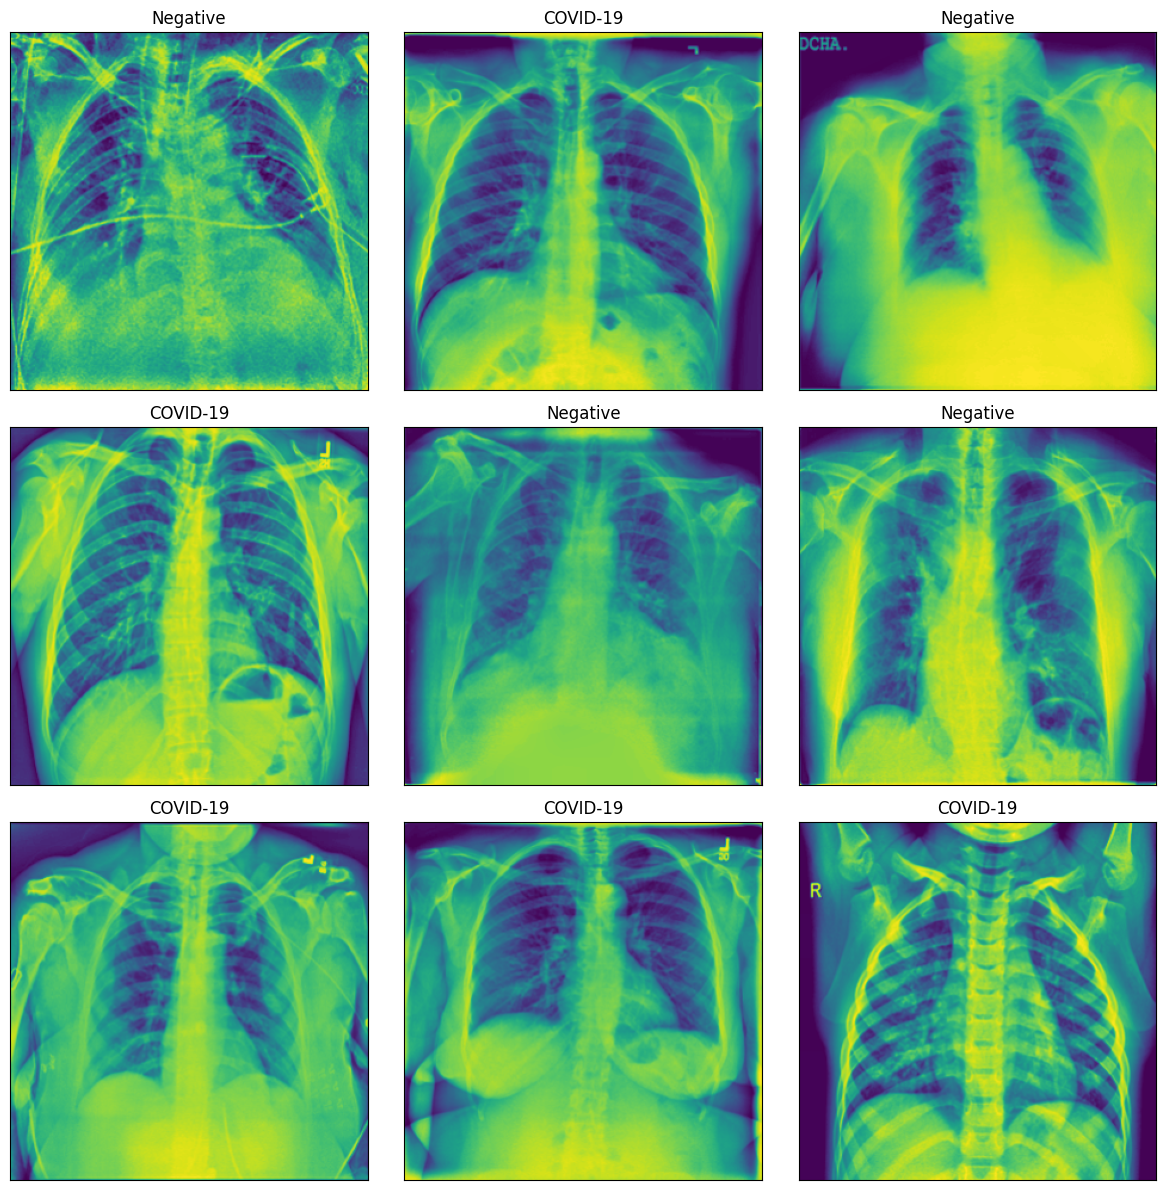

In [15]:
plt.figure(figsize=(12, 12))
for i in range(min(9, len(train_dataset))):
    plt.subplot(3, 3, i + 1)
    img, label_array = train_dataset[i]
    # For binary, label_array is directly an integer (0 or 1) from ImageFolder
    title_str = config.target_disease if label_array == 1 else "Negative"
    img = img.squeeze().cpu().numpy()
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title(title_str)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

In [16]:
class ResidualBlock(nn.Module):
    """
    Implements a **Residual Block**, the fundamental building block of ResNet.

    Mathematically, given an input $x$, the block learns a residual function $F(x)$.
    The output $y$ is computed as:
    $$ y = \sigma(F(x, \{W_i\}) + x) $$
    where $W_i$ represent the weights of the layers, and $\sigma$ is the activation function (ReLU/LeakyReLU).

    **Scientific Rationale:**
    Deep networks often suffer from the **degradation problem** and **vanishing gradients**.
    By introducing an **identity shortcut connection** (the $+x$ term), the gradient can flow directly
    through the network during backpropagation. This acts as a "gradient superhighway,"
    facilitating the optimization of very deep architectures.

    **Structure:**
    1. **Main Path ($F(x)$)**: Conv -> BN -> Activation -> Conv -> BN
    2. **Shortcut Path**: Identity mapping (or 1x1 Conv for dimension matching)
    3. **Addition**: Element-wise sum of Main and Shortcut paths.

    Args:
        in_channels (int): Number of input feature channels.
        out_channels (int): Number of output feature channels.
    """

    def __init__(self, in_channels, out_channels):
        super().__init__()

        # The main path (F(x)): Convolution -> BN -> Activation -> Convolution -> BN
        self.main = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

        # The shortcut path (x):
        # If dimensions change, use 1x1 Conv to match sizes. Otherwise, pass identity.
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels),
            )
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        # Result is F(x) + x, followed by the final activation
        return nn.functional.leaky_relu(self.main(x) + self.shortcut(x), 0.2)

<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-1791349947.py:7: SyntaxWarning: invalid escape sequence '\s'
  $$ y = \sigma(F(x, \{W_i\}) + x) $$


In [17]:
class ReadHeads(nn.Module):
    r"""
    Implements a Multi-Scale Feature Extraction module, conceptually similar to the **Inception** module.

    **Scientific Rationale:**
    Optimal kernel size varies depending on the size of the salient features in the image.
    Instead of committing to a single kernel size, this module applies multiple convolutions
    with different receptive fields ($k \in \{3, 5, 7\}$) in parallel.

    Mathematically, the output $Y$ is the concatenation of feature maps from different branches:
    $$ Y = \text{Concat}(\phi_3(X), \phi_5(X), \phi_7(X)) $$
    where $\phi_k$ represents the transformation (Conv + BN + Activation) with kernel size $k$.

    This allows the network to simultaneously capture:
    - **Local textures/details** (small kernels, e.g., 3x3)
    - **Global shape/context** (large kernels, e.g., 7x7)

    Args:
        in_channels (int): Number of input channels.
        kernel_sizes (list[int]): List of kernel sizes for parallel branches.
        feature_per_head (int): Number of filters for each branch.
    """

    def __init__(
        self,
        in_channels=3,
        kernel_sizes: list[int] = [3, 5, 7],
        feature_per_head: int = 64,
    ) -> None:
        super().__init__()
        self.read_heads = nn.ModuleList()
        for ks in kernel_sizes:
            self.read_heads.append(
                nn.Sequential(
                    nn.Conv2d(
                        in_channels,
                        feature_per_head,
                        kernel_size=ks,
                        padding=(ks - 1) // 2,
                    ),
                    nn.BatchNorm2d(feature_per_head),
                    nn.LeakyReLU(0.2, inplace=True),
                )
            )

    def forward(self, x: Tensor) -> Tensor:
        return torch.cat([head(x) for head in self.read_heads], dim=1)

In [18]:
class Covid_Net(nn.Module):
    def __init__(
        self,
        kernel_sizes: list[int],
        number_of_classes: int,
        feature_per_head: int = 64,
    ) -> None:
        """
        **Covid_Net Architecture**

        A custom deep convolutional neural network optimized for medical image classification.

        **Architectural Design:**
        1.  **Multi-Scale Input Processing (ReadHeads)**:
            - Replaces standard initial convolutions with parallel multi-kernel extraction.
            - Ensures diverse feature representation from the raw input.
        2.  **Hierarchical Feature Learning**:
            - Uses a sequence of **Residual Blocks** interspersed with Downsampling layers.
            - Progressively reduces spatial resolution ($H, W$) while increasing semantic depth (Channels).
        3.  **Learning Bottleneck**:
            - A dense sequence of residual blocks at the lowest spatial resolution to process high-level interactions.
        4.  **Classification Head**:
            - Global Average Pooling (GAP) to obtain translation-invariant features.
            - Multi-Layer Perceptron (MLP) for final decision boundary.

        Args:
            kernel_sizes (list[int]): Kernels for the input reading heads.
            number_of_classes (int): Number of output classes (1 for binary).
            feature_per_head (int): Filters per head.
        """
        super().__init__()

        # 1. Multi-Scale Feature Extraction
        # Captures features at different scales (3x3, 5x5, 7x7) simultaneously
        self.read_heads = ReadHeads(
            in_channels=1, kernel_sizes=kernel_sizes, feature_per_head=feature_per_head
        )

        # Calculate total channels resulting from concatenating the heads
        # e.g., if 3 kernels and 64 features per head, channel_count = 192
        channel_count = feature_per_head * len(kernel_sizes)

        # 2. Downsampling Sequence
        # Processes features and reduces image size (H, W) using strided convolutions
        self.downsampling = nn.Sequential(
            ResidualBlock(channel_count, channel_count),
            nn.Conv2d(
                channel_count, channel_count, kernel_size=4, stride=2, padding=1
            ),  # Halves H, W
            ResidualBlock(channel_count, channel_count),
            nn.Conv2d(
                channel_count, channel_count, kernel_size=4, stride=2, padding=1
            ),  # Halves H, W
            ResidualBlock(channel_count, channel_count),
            nn.Conv2d(
                channel_count, channel_count, kernel_size=4, stride=2, padding=1
            ),  # Halves H, W
            ResidualBlock(channel_count, channel_count),
        )
        self.learning_bottleneck = nn.Sequential(
            ResidualBlock(channel_count, channel_count * 2),
            ResidualBlock(channel_count * 2, channel_count * 4),
            ResidualBlock(channel_count * 4, channel_count * 8),
        )
        # 3. Global Pooling
        # Converts spatial maps (Channels, H, W) into a vector (Channels)
        self.global_pool = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),  # Forces output to be [B, Channels, 1, 1]
            nn.Flatten(),  # Flattens to [B, Channels]
        )

        # 4. Classifier
        # NOTE: I changed the input size from the hardcoded '1536' to 'channel_count'
        # so it matches the output of the read_heads/downsampling (e.g., 192).
        self.classifier = nn.Sequential(
            nn.Linear(channel_count * 8, 12288),  # Adjusted input dim
            nn.LeakyReLU(0.2),
            nn.Linear(12288, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, number_of_classes),
        )

    def forward(self, x):
        """
        Forward pass defining the data flow through the network.

        Args:
            x (Tensor): Input image batch of shape [Batch, 1, H, W]
        """

        # Step 1: Extract features using the Inception-like ReadHeads
        # Input: [B, 1, H, W] -> Output: [B, channel_count, H, W]
        x = self.read_heads(x)

        # Step 2: Pass through the Downsampling/Residual blocks
        # Reduces spatial dimensions while refining features
        # Output: [B, channel_count, H/8, W/8] (due to 3 strided convs)
        x = self.downsampling(x)

        x = self.learning_bottleneck(x)

        # Step 3: Global Average Pooling and Flattening
        # Aggregates spatial information into a single feature vector per image
        # Output: [B, channel_count]
        x = self.global_pool(x)

        # Step 4: Classification MLP
        # Maps features to class probabilities (logits)
        # Output: [B, number_of_classes]
        return self.classifier(x)

In [19]:
model = Covid_Net(config.kernel_sizes, 1)
model.to(config.device)

# Load existing weights if available
weights_path = config.model_weights + config.hra_net_name
if os.path.exists(weights_path):
    print(f"Loading existing model weights from {weights_path}")
    model.load_state_dict(torch.load(weights_path, map_location=config.device))
else:
    print("No existing weights found. Starting from scratch.")
summary(model, (1, *config.image_size))

No existing weights found. Starting from scratch.

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 300, 300]             640
       BatchNorm2d-2         [-1, 64, 300, 300]             128
         LeakyReLU-3         [-1, 64, 300, 300]               0
            Conv2d-4         [-1, 64, 300, 300]           1,664
       BatchNorm2d-5         [-1, 64, 300, 300]             128
         LeakyReLU-6         [-1, 64, 300, 300]               0
            Conv2d-7         [-1, 64, 300, 300]           3,200
       BatchNorm2d-8         [-1, 64, 300, 300]             128
         LeakyReLU-9         [-1, 64, 300, 300]               0
        ReadHeads-10        [-1, 192, 300, 300]               0
           Conv2d-11        [-1, 192, 300, 300]         331,776
      BatchNorm2d-12        [-1, 192, 300, 300]             384
        LeakyReLU-13        [-1, 192, 300, 300]               0
           Conv2d-14        [-1, 192, 3

In [20]:
def moving_average(data, window_size=5):
    """
    Applies a simple moving average smoothing to the data.
    """
    if len(data) < window_size:
        return np.array(data)
    # Equivalent to convolution with ones/window_size
    return np.convolve(data, np.ones(window_size) / window_size, mode="valid")


def interpolate_metrics(current_steps, current_values, target_steps):
    """
    Interpolates metric values to match the granularity of target_steps.
    Useful for aligning sparse test evaluations with dense training logs.
    """
    if len(current_steps) == 0:
        return []
    # Linear interpolation
    return np.interp(target_steps, current_steps, current_values)


def evaluate(model, loader, criterion, device):
    """
    Evaluates the model on the given loader (Validation/Test).
    Returns average loss, accuracy, and arrays of true labels and predicted probabilities.
    """
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    y_true = []
    y_scores = []

    with torch.no_grad():
        for data, target in loader:
            data = data.to(device)
            # Ensure target is float for BCE and correct shape [B, 1]
            target_float = target.to(device).float().unsqueeze(1)

            outputs = model(data)
            loss = criterion(outputs, target_float)
            val_loss += loss.item()

            # Sigmoid for probability
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()

            correct += (preds == target_float).sum().item()
            total += target.size(0)

            y_true.extend(target_float.cpu().numpy().flatten())
            y_scores.extend(probs.cpu().numpy().flatten())

    val_loss /= len(loader)
    acc = correct / total if total > 0 else 0
    return val_loss, acc, np.array(y_true), np.array(y_scores)


def plot_results(history, y_true_test, y_scores_test):
    """
    Generates scientific visualization plots:
    1. Loss & Accuracy Curves (smoothed)
    2. Learning Rate Schedule
    3. ROC Curve
    4. Precision-Recall Curve
    5. F1 Score vs Threshold
    6. Confusion Matrix
    """
    sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)

    # Prepare data for Line Plots
    train_steps = np.array(history["step"])
    train_loss = np.array(history["train_loss"])
    train_acc = np.array(history["train_acc"])

    # Extend/Interpolate Test metrics to match Training steps for comparison
    test_steps_log = np.array(history["test_step"])
    test_loss_log = np.array(history["test_loss"])
    test_acc_log = np.array(history["test_acc"])

    # Interpolate for plotting if we have valid test logs
    if len(test_steps_log) > 1:
        test_loss_interp = interpolate_metrics(
            test_steps_log, test_loss_log, train_steps
        )
        test_acc_interp = interpolate_metrics(test_steps_log, test_acc_log, train_steps)
    else:
        # Fallback if only 1 point or empty
        test_loss_interp = np.full_like(
            train_loss, test_loss_log[0] if len(test_loss_log) > 0 else 0
        )
        test_acc_interp = np.full_like(
            train_acc, test_acc_log[0] if len(test_acc_log) > 0 else 0
        )

    # Apply Moving Average for smoothing
    window = 10
    if len(train_steps) < window:
        t_steps_ma = train_steps
    else:
        # Note: Moving average reduces array size by window-1
        t_steps_ma = train_steps[window - 1 :]

    train_loss_ma = moving_average(train_loss, window)
    test_loss_ma = moving_average(test_loss_interp, window)

    train_acc_ma = moving_average(train_acc, window)
    test_acc_ma = moving_average(test_acc_interp, window)

    # Create Figure
    fig = plt.figure(figsize=(20, 15))
    gs = fig.add_gridspec(3, 3)

    # 1. Loss Curve
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(t_steps_ma, train_loss_ma, label="Train Loss (MA)", color="tab:blue")
    ax1.plot(
        t_steps_ma,
        test_loss_ma,
        label="Test Loss (MA Extended)",
        color="tab:orange",
        linestyle="--",
    )
    ax1.set_title("Loss Curve (Learning Curve)")
    ax1.set_xlabel("Steps")
    ax1.set_ylabel("Loss")
    ax1.legend()

    # 2. Accuracy Curve
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(t_steps_ma, train_acc_ma, label="Train Acc (MA)", color="tab:green")
    ax2.plot(
        t_steps_ma,
        test_acc_ma,
        label="Test Acc (MA Extended)",
        color="tab:red",
        linestyle="--",
    )
    ax2.set_title("Accuracy Curve")
    ax2.set_xlabel("Steps")
    ax2.set_ylabel("Accuracy")
    ax2.legend()

    # 3. Learning Rate Schedule
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.plot(history["step"], history["lr"], color="purple")
    ax3.set_title("Learning Rate Schedule")
    ax3.set_xlabel("Steps")
    ax3.set_ylabel("LR")

    # 4. ROC Curve
    ax4 = fig.add_subplot(gs[1, 0])
    fpr, tpr, _ = roc_curve(y_true_test, y_scores_test)
    roc_auc = auc(fpr, tpr)
    ax4.plot(
        fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})"
    )
    ax4.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    ax4.set_title("ROC Curve")
    ax4.set_xlabel("False Positive Rate")
    ax4.set_ylabel("True Positive Rate")
    ax4.legend(loc="lower right")

    # 5. Precision-Recall Curve (Good for Imbalanced Data)
    ax5 = fig.add_subplot(gs[1, 1])
    precision, recall, _ = precision_recall_curve(y_true_test, y_scores_test)
    ax5.plot(recall, precision, color="teal", lw=2)
    ax5.set_title("Precision-Recall Curve")
    ax5.set_xlabel("Recall")
    ax5.set_ylabel("Precision")

    # 6. F1 Score vs Threshold
    ax6 = fig.add_subplot(gs[1, 2])
    thresholds = np.linspace(0, 1, 101)
    f1_scores = [
        f1_score(y_true_test, (y_scores_test > t).astype(int)) for t in thresholds
    ]
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]
    best_f1 = f1_scores[best_idx]

    ax6.plot(thresholds, f1_scores, color="magenta")
    ax6.axvline(
        best_threshold,
        color="k",
        linestyle="--",
        label=f"Best Thresh: {best_threshold:.2f}",
    )
    ax6.set_title(f"F1 Score vs Threshold (Max F1: {best_f1:.2f})")
    ax6.set_xlabel("Threshold")
    ax6.set_ylabel("F1 Score")
    ax6.legend()

    # 7. Confusion Matrix (at Best Threshold)
    ax7 = fig.add_subplot(gs[2, 1])
    final_preds = (y_scores_test > best_threshold).astype(int)
    cm = confusion_matrix(y_true_test, final_preds)

    # Calculate exact counts
    tn, fp, fn, tp = cm.ravel()

    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        ax=ax7,
        cbar=False,
        xticklabels=["Negative", "Positive"],
        yticklabels=["Negative", "Positive"],
    )
    ax7.set_title(f"Confusion Matrix\nTP={tp}, FP={fp}, TN={tn}, FN={fn}")
    ax7.set_ylabel("True Label")
    ax7.set_xlabel("Predicted Label")

    plt.tight_layout()
    plt.savefig("training_results_dashboard.png")  # Save artifact
    print("Saved training_results_dashboard.png")
    plt.show()

    # Robust display for Jupyter/Colab notebooks
    try:
        from IPython.display import Image, display

        display(Image(filename="training_results_dashboard.png"))
    except ImportError:
        pass
    plt.close(fig)  # Close the main figure to free memory

    # ==========================================
    # Save Individual Plots
    # ==========================================

    # helper to save a single plot
    def save_single_plot(filename, plot_func):
        fig_single = plt.figure(figsize=(10, 8))
        plot_func(fig_single)
        plt.tight_layout()
        plt.savefig(filename)
        print(f"Saved {filename}")
        plt.close(fig_single)

    # 1. Loss Curve
    def plot_loss(fig):
        ax = fig.add_subplot(111)
        ax.plot(t_steps_ma, train_loss_ma, label="Train Loss (MA)", color="tab:blue")
        ax.plot(
            t_steps_ma,
            test_loss_ma,
            label="Test Loss (MA Extended)",
            color="tab:orange",
            linestyle="--",
        )
        ax.set_title("Loss Curve (Learning Curve)")
        ax.set_xlabel("Steps")
        ax.set_ylabel("Loss")
        ax.legend()

    save_single_plot("loss_curve.png", plot_loss)

    # 2. Accuracy Curve
    def plot_acc(fig):
        ax = fig.add_subplot(111)
        ax.plot(t_steps_ma, train_acc_ma, label="Train Acc (MA)", color="tab:green")
        ax.plot(
            t_steps_ma,
            test_acc_ma,
            label="Test Acc (MA Extended)",
            color="tab:red",
            linestyle="--",
        )
        ax.set_title("Accuracy Curve")
        ax.set_xlabel("Steps")
        ax.set_ylabel("Accuracy")
        ax.legend()

    save_single_plot("accuracy_curve.png", plot_acc)

    # 3. Learning Rate Schedule
    def plot_lr(fig):
        ax = fig.add_subplot(111)
        ax.plot(history["step"], history["lr"], color="purple")
        ax.set_title("Learning Rate Schedule")
        ax.set_xlabel("Steps")
        ax.set_ylabel("LR")

    save_single_plot("learning_rate_schedule.png", plot_lr)

    # 4. ROC Curve
    def plot_roc(fig):
        ax = fig.add_subplot(111)
        ax.plot(
            fpr,
            tpr,
            color="darkorange",
            lw=2,
            label=f"ROC curve (area = {roc_auc:.2f})",
        )
        ax.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
        ax.set_title("ROC Curve")
        ax.set_xlabel("False Positive Rate")
        ax.set_ylabel("True Positive Rate")
        ax.legend(loc="lower right")

    save_single_plot("roc_curve.png", plot_roc)

    # 5. Precision-Recall Curve
    def plot_pr(fig):
        ax = fig.add_subplot(111)
        ax.plot(recall, precision, color="teal", lw=2)
        ax.set_title("Precision-Recall Curve")
        ax.set_xlabel("Recall")
        ax.set_ylabel("Precision")

    save_single_plot("precision_recall_curve.png", plot_pr)

    # 6. F1 Score vs Threshold
    def plot_f1(fig):
        ax = fig.add_subplot(111)
        ax.plot(thresholds, f1_scores, color="magenta")
        ax.axvline(
            best_threshold,
            color="k",
            linestyle="--",
            label=f"Best Thresh: {best_threshold:.2f}",
        )
        ax.set_title(f"F1 Score vs Threshold (Max F1: {best_f1:.2f})")
        ax.set_xlabel("Threshold")
        ax.set_ylabel("F1 Score")
        ax.legend()

    save_single_plot("f1_score_threshold.png", plot_f1)

    # 7. Confusion Matrix
    def plot_cm(fig):
        ax = fig.add_subplot(111)
        sns.heatmap(
            cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            ax=ax,
            cbar=False,
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"],
        )
        ax.set_title(f"Confusion Matrix\nTP={tp}, FP={fp}, TN={tn}, FN={fn}")
        ax.set_ylabel("True Label")
        ax.set_xlabel("Predicted Label")

    save_single_plot("confusion_matrix.png", plot_cm)


def train(config, model, train_loader, test_loader):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(
        model.parameters(),
        lr=config.pre_training_learning_rate,
        weight_decay=config.weight_decay,
    )

    # scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=2)
    # Changed to CosineAnnealingWarmRestarts with dynamic T_0 based on batch size
    batches_per_epoch = len(train_loader)
    print(f"Scheduler T_0 set to {batches_per_epoch} (batches per epoch)")
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=batches_per_epoch, T_mult=config.T_mult
    )

    history = {
        "step": [],
        "train_loss": [],
        "train_acc": [],
        "test_step": [],
        "test_loss": [],
        "test_acc": [],
        "lr": [],
    }

    global_step = 0
    log_interval = 100  # Log every 100 steps as requested

    print(f"Starting training for {config.num_epochs} epochs...")

    for epoch in range(config.num_epochs):
        model.train()
        loop = tqdm(train_loader, desc=f"Epoch {epoch + 1}")

        for batch_idx, (data, target) in enumerate(loop):
            data = data.to(config.device)
            target = target.to(config.device).float().unsqueeze(1)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            # Step the scheduler every batch for Cosine Annealing
            scheduler.step()

            global_step += 1

            # --- Logging ---
            if global_step % log_interval == 0:
                # Calculate Training Metrics (Instantaneous or Batch)
                probs = torch.sigmoid(output)
                preds = (probs > 0.5).float()
                acc = (preds == target).sum().item() / target.size(0)

                history["step"].append(global_step)
                history["train_loss"].append(loss.item())
                history["train_acc"].append(acc)
                history["lr"].append(optimizer.param_groups[0]["lr"])

                # --- Evaluation on Test Set ---
                # "extend testing data ... by moving avg" -> Log frequently to get dense data
                test_loss, test_acc, _, _ = evaluate(
                    model, test_loader, criterion, config.device
                )
                history["test_step"].append(global_step)
                history["test_loss"].append(test_loss)
                history["test_acc"].append(test_acc)

                # Update loop description
                loop.set_postfix(loss=loss.item(), acc=acc, test_loss=test_loss)

                # Note: ReduceLROnPlateau step was here.
                # CosineAnnealing steps per batch, so we don't step here.

                # Switch back to train mode after eval
                model.train()

    return history

Scheduler T_0 set to 691 (batches per epoch)

Starting training for 1 epochs...

Epoch 1: 100%|██████████| 691/691 [50:20<00:00,  4.37s/it, acc=1, loss=0.197, test_loss=0.358]


Running final evaluation...

Saved training_results_dashboard.png

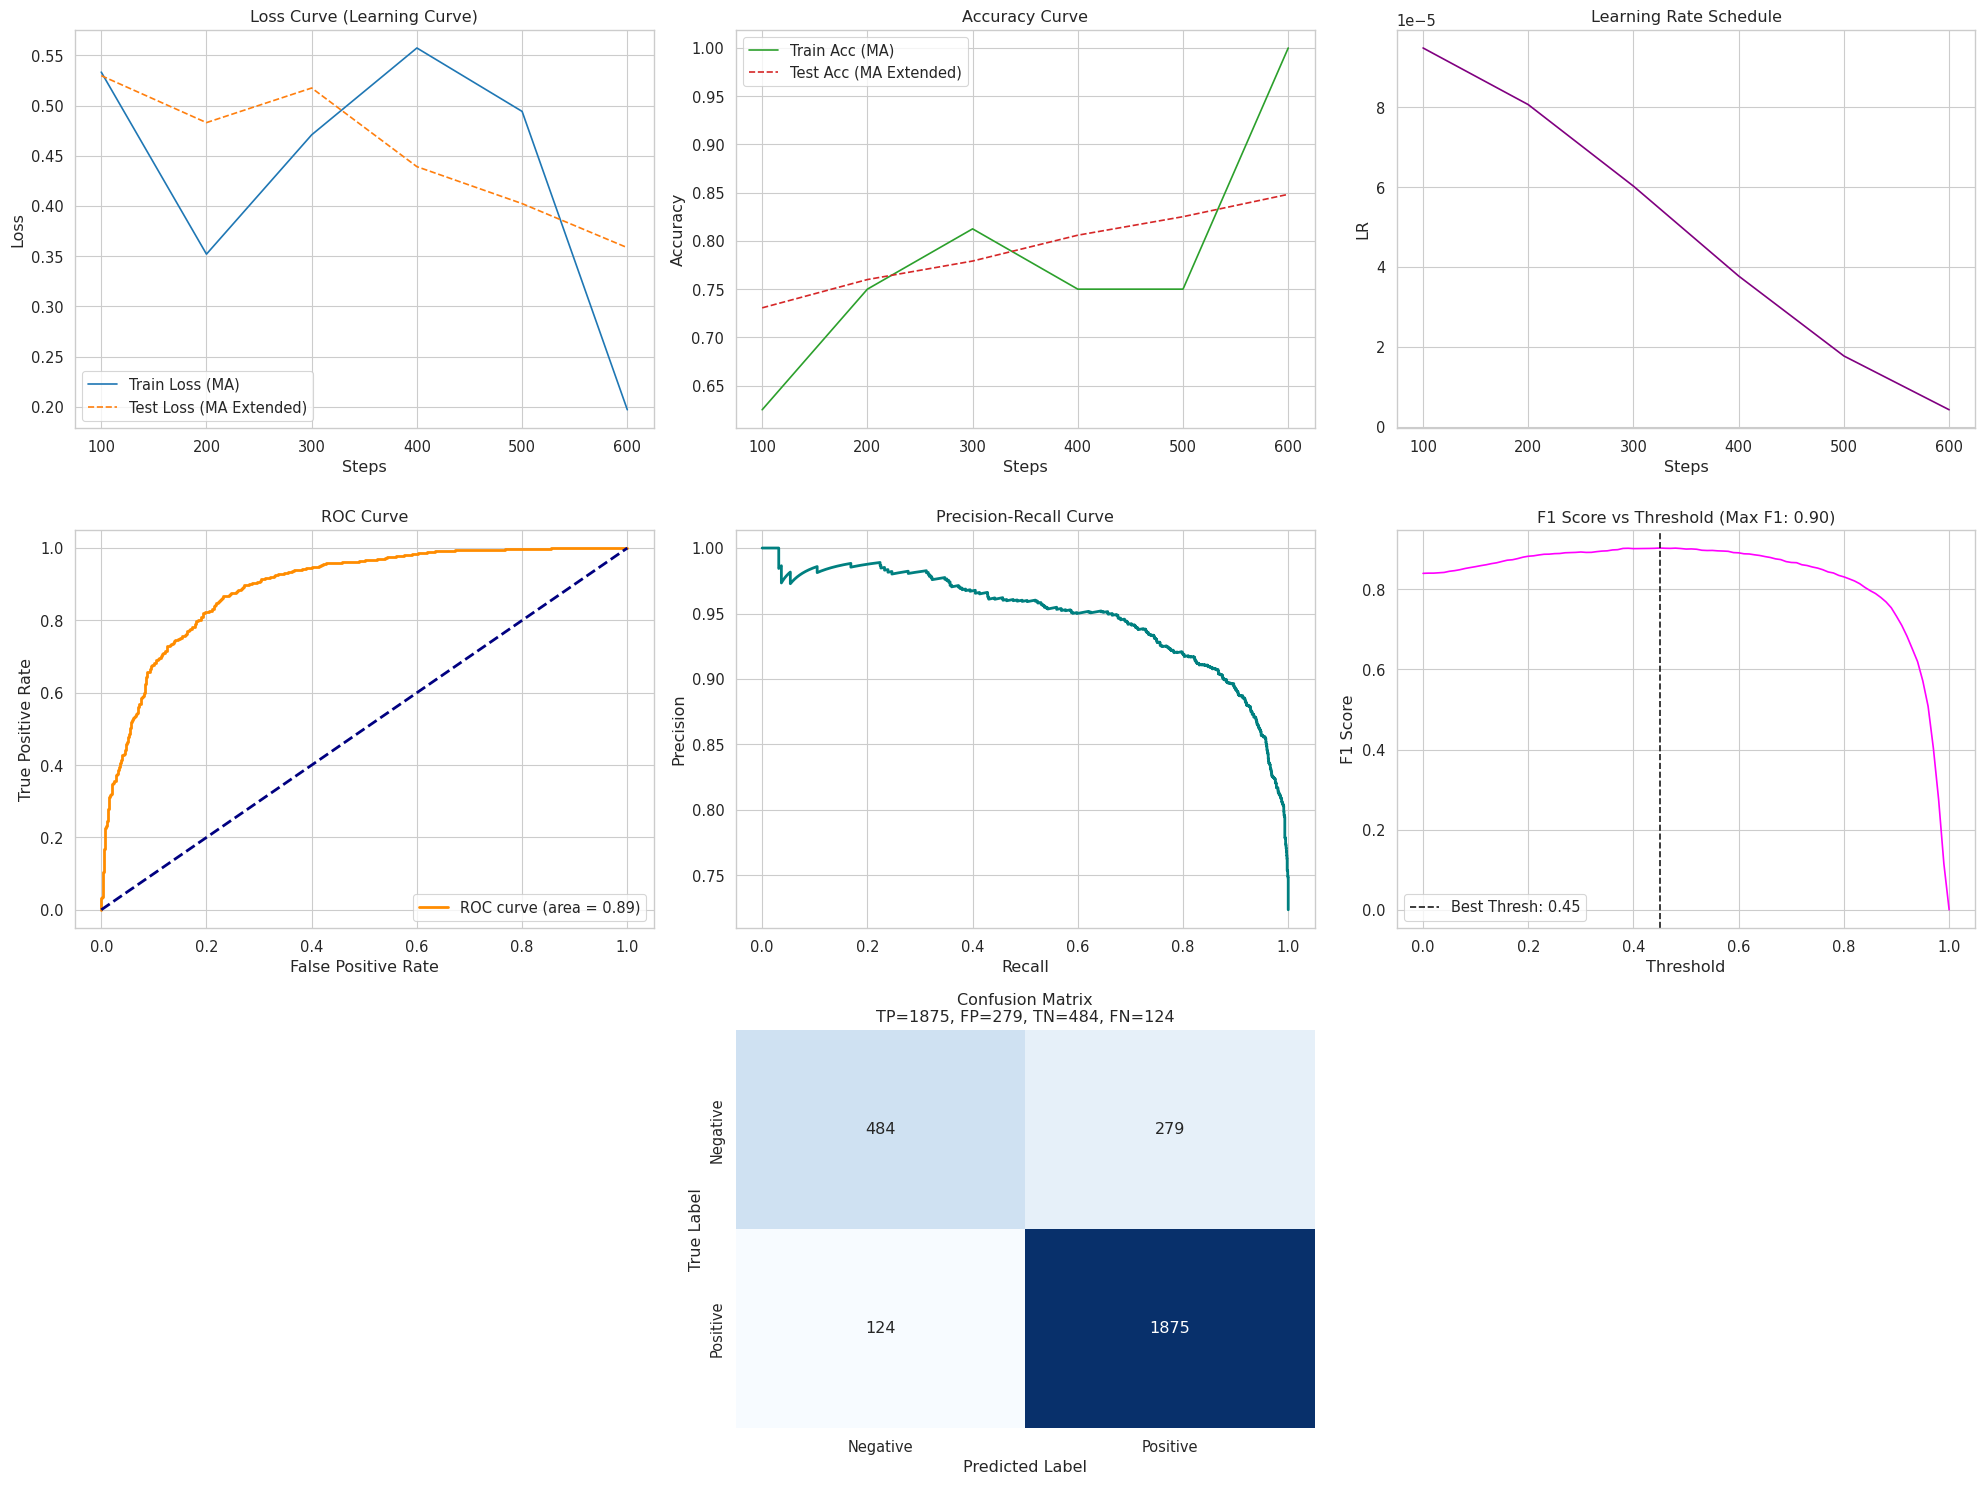

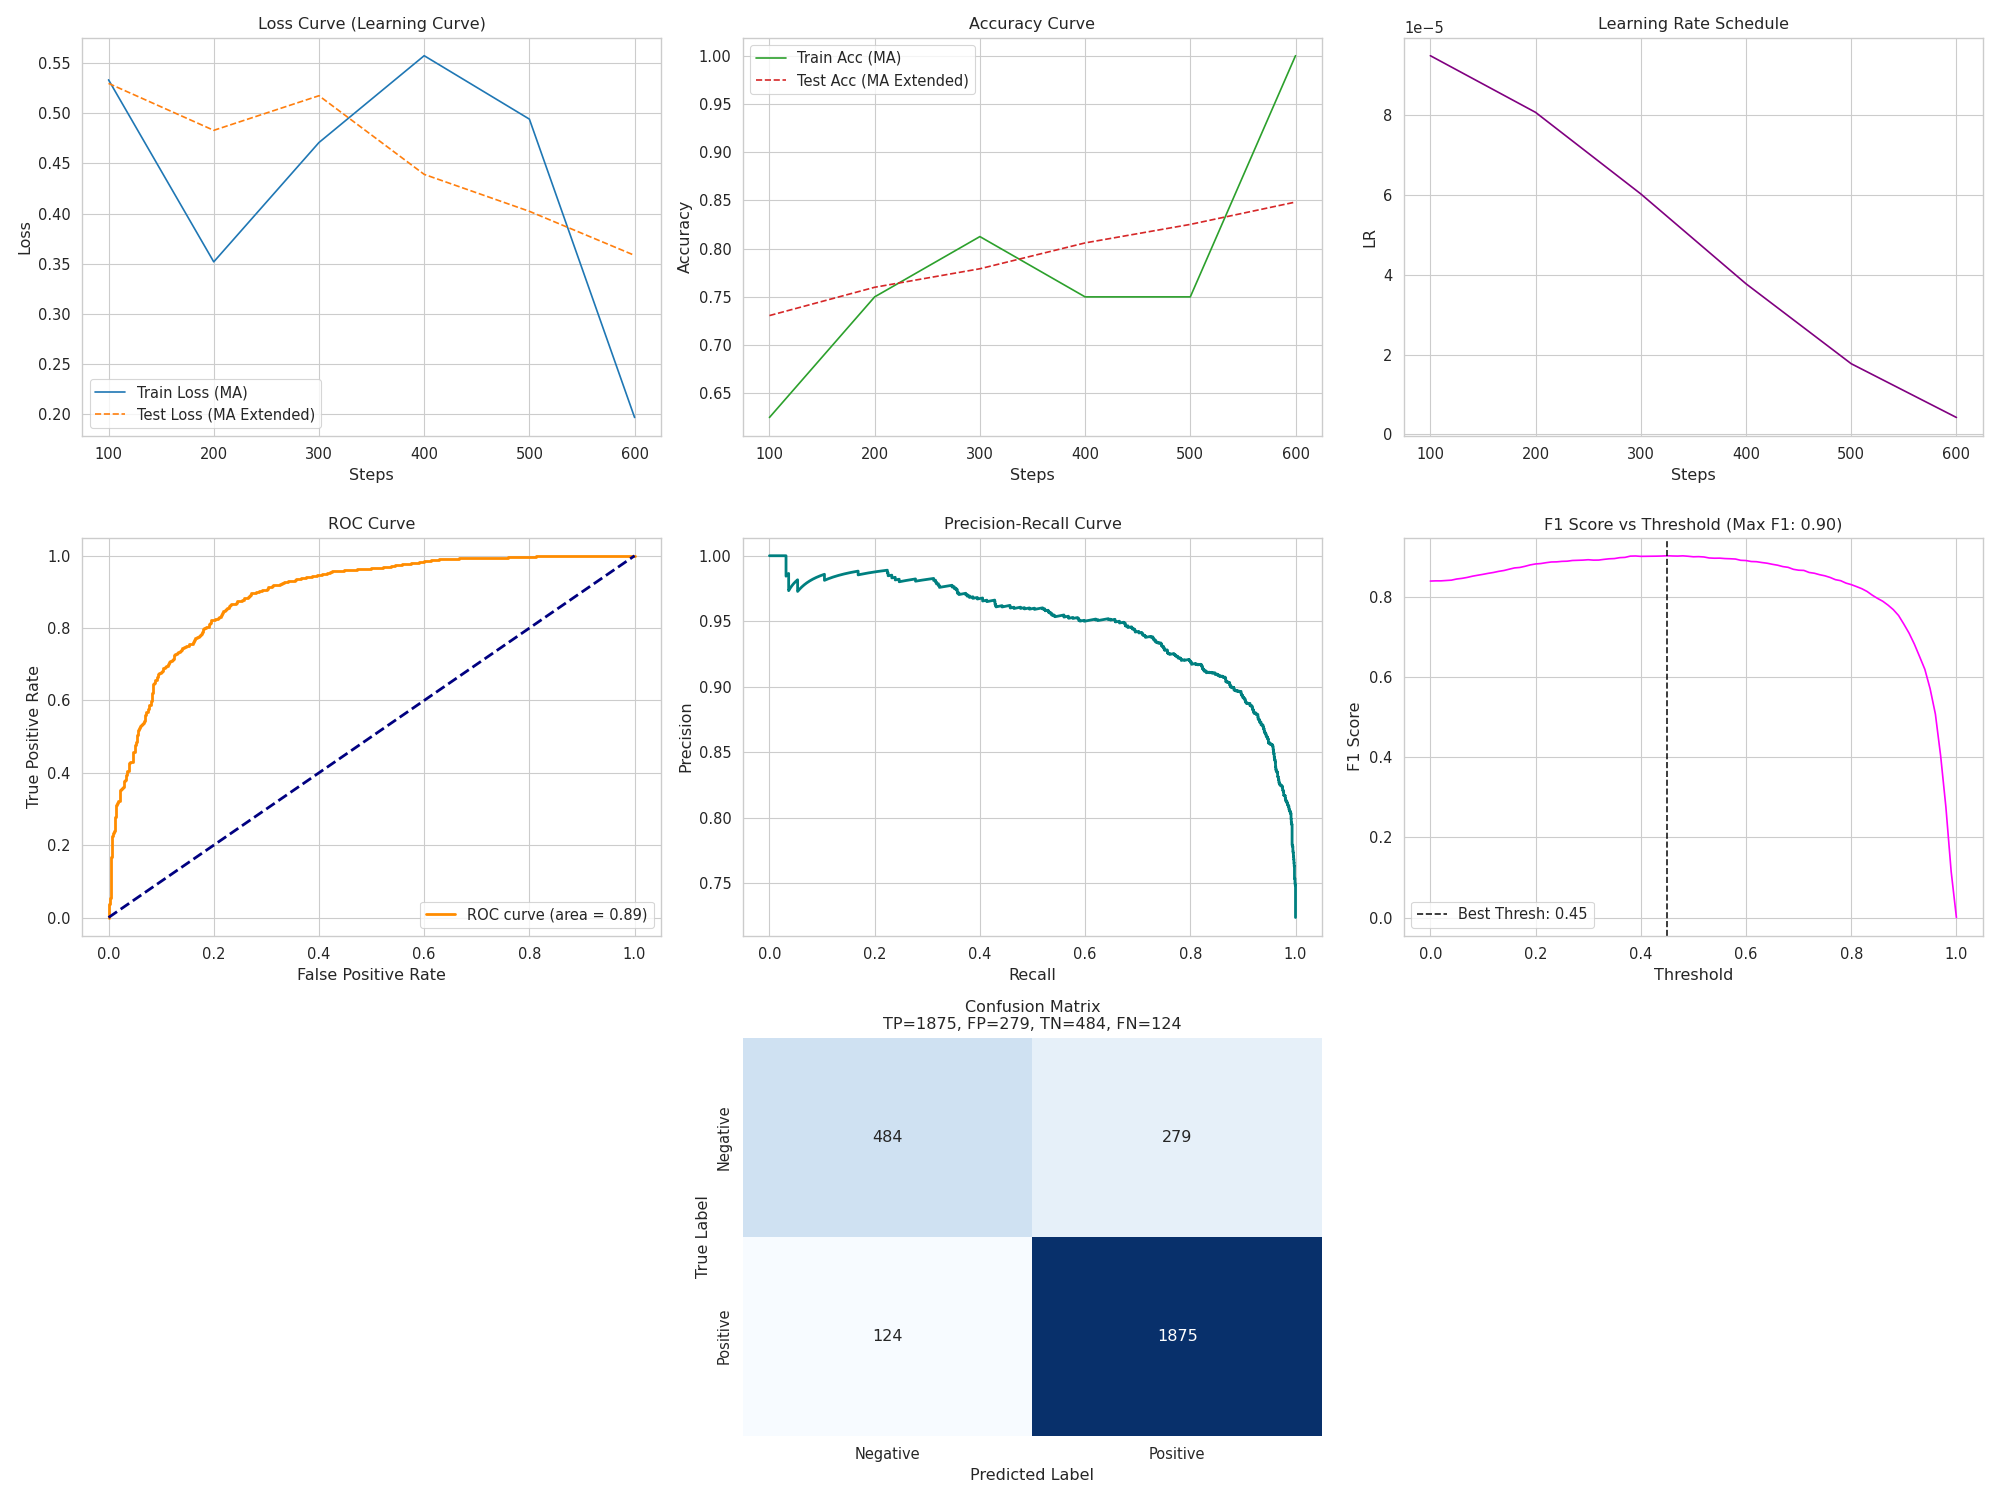

Saved loss_curve.png

Saved accuracy_curve.png

Saved learning_rate_schedule.png

Saved roc_curve.png

Saved precision_recall_curve.png

Saved f1_score_threshold.png

Saved confusion_matrix.png

In [21]:
# 1. Train
history = train(config, model, train_loader, test_loader)

# 2. Final Evaluation
print("Running final evaluation...")
_, _, y_true, y_scores = evaluate(
    model, test_loader, nn.BCEWithLogitsLoss(), config.device
)

# 3. Visualize
plot_results(history, y_true, y_scores)

In [22]:
torch.save(model.state_dict(), weights_path)
print(f"Model weights saved to {weights_path}")

Model weights saved to ./model_weights/model.pth